In [ ]:
pip install mlflow torchinfo

## Import lib

In [1]:
# Basic data manipulations
import pandas as pd
import numpy as np


# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder
! pip install torchsummary
import torchsummary



# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Pytorch way of data augmentation.
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split

#PyTorch Monitoring to MLflow
import mlflow

ModuleNotFoundError: No module named 'pandas'

Accessing the Dataset from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_path = '/content/drive/MyDrive/SDS-myconet/DeFungi/'

## Create dataframe

In [4]:
#root_path = '/kaggle/input/defungi/'
df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
label_dict = {
    "H1":0,
    "H2":1,
    "H3":2,
    "H5":3,
    "H6":4,
}
for key in label_dict:
    img_path = os.path.join(root_path, key)
    jpg_path_list = glob(img_path+'/*.jpg')
    for jpg_path in jpg_path_list:
        new_data_frame =pd.DataFrame({"path":jpg_path,"label":key, "class_id":label_dict[key]}, index=[1])
        df = pd.concat([df, new_data_frame], ignore_index=True)

df[["path"]] = df[["path"]].astype(str)
df[["label"]] = df[["label"]].astype(str)
df[["class_id"]] = df[["class_id"]].astype(int)

Display DataFrame

In [5]:
df.head()

,path,label,class_id
0,/content/drive/MyDrive/SDS-myconet/DeFungi/H1/...,H1,0
1,/content/drive/MyDrive/SDS-myconet/DeFungi/H1/...,H1,0
2,/content/drive/MyDrive/SDS-myconet/DeFungi/H1/...,H1,0
3,/content/drive/MyDrive/SDS-myconet/DeFungi/H1/...,H1,0
4,/content/drive/MyDrive/SDS-myconet/DeFungi/H1/...,H1,0


##Show Class Distribution

**Class distribution in histogram**

(array([4404.,    0., 2334.,    0.,    0.,  819.,    0.,  821.,    0.,
         739.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

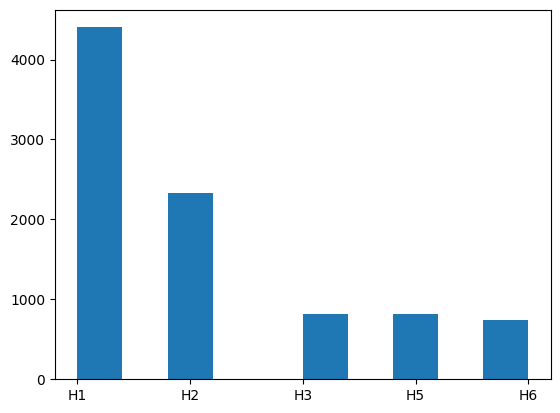

In [7]:
plt.hist(df['label'])

**Handling Class Imbalance**

Since our dataset is imbalanced and we want to use a weighted loss function, we will use the weight argument in PyTorch's loss functions like nn.CrossEntropyLoss. This allows us to assign different weights to the loss for each class, giving more importance to the minority classes.


In [6]:
# Calculate class frequencies
class_counts = df['class_id'].value_counts().sort_index()
total_samples = len(df)
class_weights = total_samples / (len(class_counts) * class_counts)

# Convert to a PyTorch tensor and move to the device
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float32).to(device)
print("Class Weights:", class_weights_tensor)

Class Weights: tensor([0.4140, 0.7812, 2.2264, 2.2210, 2.4674], device='cuda:0')


## Display sample images from Dataset

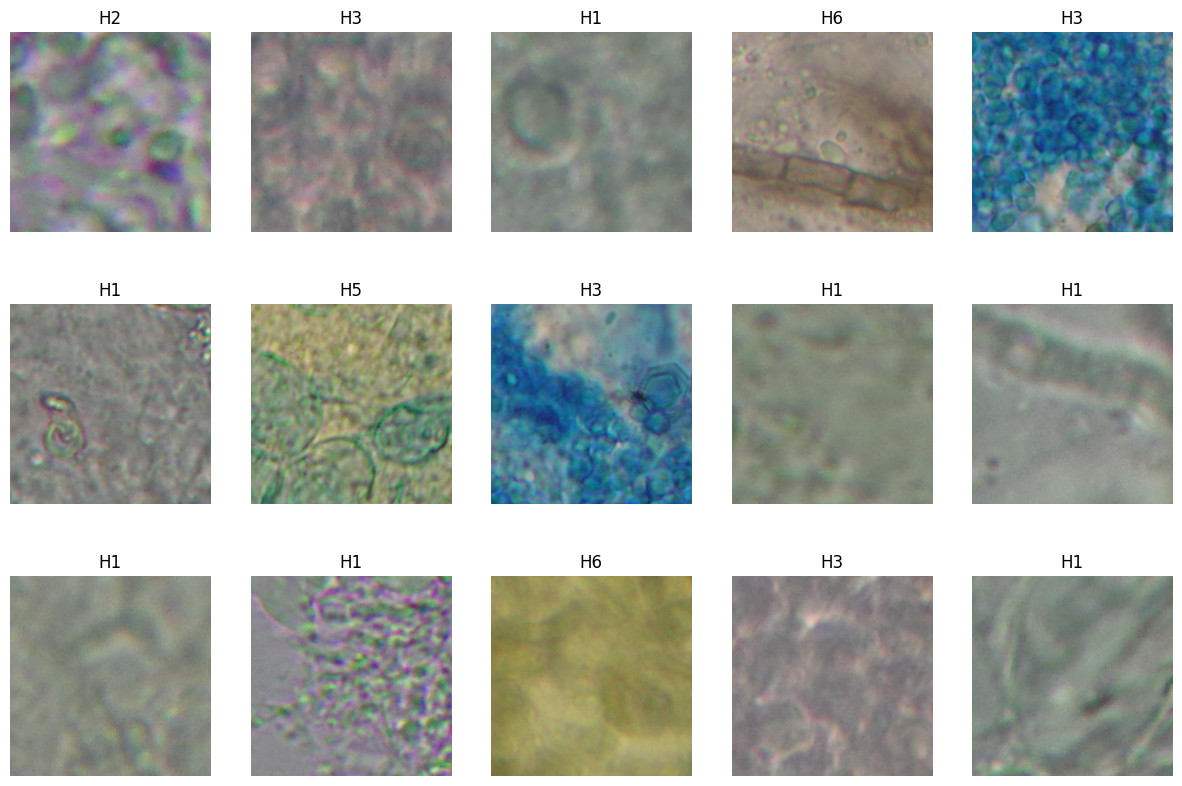

In [7]:
show_imgs = 15
idx = np.random.randint(0, len(df),size=show_imgs)
fig, axes = plt.subplots(show_imgs//5, 5, figsize=(15,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    full_path = df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(df.loc[idx[i]]['label'])
    ax.set_axis_off()

## Create Image Transformations

**Image Transformations Explained**
The code defines three sets of transformations using torchvision.transforms.v2.Compose:

train_transforms: These transformations are applied specifically to the images used for training the model. They include several data augmentation techniques to help the model generalize better and prevent overfitting.

eval_transforms: These transformations are for the validation set, which is used during training to evaluate the model's performance on data it hasn't seen before. Data augmentation is typically not applied here, only transformations needed to get the images into the correct format and size for the model.

test_transforms: These transformations are for the test set, which is used for a final evaluation of the trained model. Like the validation set, data augmentation is not applied here.

In [8]:
train_transforms = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    # v2.RandomRotation(degrees=(-20, 20)),
    v2.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.RandomErasing(p=0.5, scale=(0.1,0.15)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

eval_transforms = v2.Compose([
    v2.Resize((224,224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transforms = v2.Compose([
    v2.Resize((224,224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

**Define Custom Dataset**

This code defines a custom dataset class called MyDataset which inherits from PyTorch's Dataset class [1]


In [9]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_path = self.df.iloc[index]['path']
        # img = Image.open(image_path).convert("LA")
        img = Image.open(image_path).convert("RGB")
        # img = Image.open(image_path)
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img, class_id

**Create Dataset and Dataloader**

We use train_test_split twice. First, to split into training and a combined validation/test set, and then again to split the combined validation/test set into separate validation and test sets.

In [13]:
## Create dataset and dataloader

# Assuming 'df' dataframe is already created and contains 'label' column for stratification

# First split: 80% for training, 20% for combined validation and testing
train_df, val_test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=9898,
    stratify=df['label'] # Stratify based on the 'label' column
)

# Second split: Split the 20% (val_test_df) into 10% for validation and 10% for testing
# Since val_test_df is 20% of the original data, splitting it 50/50 will give 10% each
val_df, test_df = train_test_split(
    val_test_df,
    test_size=0.5, # 0.5 of the 20% is 10% of the original data
    random_state=9898,
    stratify=val_test_df['label'] # Stratify this split as well
)


device = torch.device("cuda" if torch.cuda.is_available else "cpu")
# num_workers can be adjusted based on your system
num_workers = 2 if device=='cuda' else 2 # Example workers setting

# Create datasets for each split
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, eval_transforms) # Using eval_transforms for validation
test_dataset = MyDataset(test_df, test_transforms) # Using test_transforms for testing


BATCH_SIZE = 32

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers) # Test loader

In [14]:
print(f'train data:{len(train_df)}')
print(f'val data:{len(val_df)}')
print(f'test data:{len(test_df)}')

train data:7293
val data:912
test data:912


## Create model

Define the custom CNN

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # The fully connected layer will be defined after we determine the input size
        self.fc = None # Initialize as None

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        # The fully connected layer is applied here
        x = self.fc(x)
        return x

## Initialize the Model

In [24]:
class_size = 5
model = SimpleCNN(num_classes=class_size)

# Determine the input size for the fully connected layer
# We will pass a dummy tensor through the convolutional and pooling layers
# to see the output shape before the flattening step.
dummy_input = torch.randn((16, 3, 224, 224)) # Use the expected input size after transforms

# Pass the dummy input through the conv and pooling layers
with torch.no_grad(): # We don't need to calculate gradients for this
    x = model.conv1(dummy_input)
    x = model.relu(x)
    x = model.maxpool(x)
    x = model.conv2(x)
    x = model.relu(x)
    x = model.maxpool(x)
    flattened_size = x.view(x.size(0), -1).size(1) # Get the size after flattening



In [28]:
x.shape

torch.Size([16, 32, 56, 56])

In [29]:
print(f'Flattened size: {flattened_size}')

Flattened size: 100352


In [27]:
# Now define the fully connected layer with the determined input size
model.fc = nn.Linear(flattened_size, class_size)
model

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=100352, out_features=5, bias=True)
)

## Training and Validation

In [30]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0
    for (data_,target_) in dataloader:
        target_ = target_.type(torch.LongTensor)
        data_, target_ = data_.to(device), target_.to(device)

        # First we'll clean the cache of optimizer
        optimizer.zero_grad()

        # Forward propagation
        outputs = model(data_)

        # Computing loss
        loss = criterion(outputs,target_)

        # Backward propagation
        loss.backward()

        # Optimizing model
        optimizer.step()

        # Computing statistics.
        epoch_loss = epoch_loss + loss.item()
        _,pred = torch.max(outputs,dim=1)
        epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    lr_scheduler.step()
    return epoch_correct/size, epoch_loss/num_batches


def eval(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    epoch_loss = 0.0
    epoch_correct = 0
    with torch.no_grad():
        # This will disable backward propagation
        model.eval()
        for (data_,target_) in dataloader:
            target_ = target_.type(torch.LongTensor)
            data_, target_ = data_.to(device), target_.to(device)

            # Forward propagation
            outputs = model(data_)

            # Computing loss
            loss = criterion(outputs,target_)
            # Computing statistics.
            epoch_loss = epoch_loss + loss.item()
            _,pred = torch.max(outputs,dim=1)
            epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    return  epoch_correct/size, epoch_loss/num_batches

In [ ]:
model.to(device)
EPOCHS = 50

logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}

#Initialize the loss function and apply the class weights:
#Pass the class_weights_tensor to the weight argument of the torch.nn.CrossEntropyLoss function.

criterion  = nn.CrossEntropyLoss(weight=class_weights_tensor)


# Optimizer which will use gradients to train model.
learning_rate = 0.0001
momentum = 0.9
weight_decay = 0.1
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
lr_milestones = [7, 14, 21, 28, 35]
multi_step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=lr_milestones, gamma=0.1)

# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss,  = train(train_loader, model, criterion, optimizer, multi_step_lr_scheduler)
    val_acc, val_loss = eval(val_loader, model, criterion)
    print(f'EPOCH: {epoch} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} \
    Learning Rate: {optimizer.param_groups[0]["lr"]}')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)
    torch.save(model.state_dict(), "last.pth")
    # chcek improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH: 0     train_loss: 0.9451, train_acc: 0.624     val_loss: 0.6850, val_acc: 0.733     Learning Rate: 0.0001


  2%|▏         | 1/50 [03:06<2:32:31, 186.77s/it]

EPOCH: 1     train_loss: 0.7099, train_acc: 0.710     val_loss: 0.5824, val_acc: 0.752     Learning Rate: 0.0001


  4%|▍         | 2/50 [05:04<1:56:53, 146.11s/it]

EPOCH: 2     train_loss: 0.6263, train_acc: 0.738     val_loss: 0.4690, val_acc: 0.822     Learning Rate: 0.0001


  6%|▌         | 3/50 [07:02<1:44:16, 133.12s/it]

EPOCH: 3     train_loss: 0.5488, train_acc: 0.776     val_loss: 0.4598, val_acc: 0.805     Learning Rate: 0.0001


  8%|▊         | 4/50 [09:01<1:37:54, 127.70s/it]

EPOCH: 4     train_loss: 0.5159, train_acc: 0.796     val_loss: 0.3913, val_acc: 0.850     Learning Rate: 0.0001


 10%|█         | 5/50 [11:03<1:34:17, 125.72s/it]

EPOCH: 5     train_loss: 0.4752, train_acc: 0.811     val_loss: 0.3330, val_acc: 0.857     Learning Rate: 0.0001


 12%|█▏        | 6/50 [13:02<1:30:25, 123.31s/it]

EPOCH: 6     train_loss: 0.4409, train_acc: 0.825     val_loss: 0.3788, val_acc: 0.845     Learning Rate: 1e-05


 14%|█▍        | 7/50 [14:59<1:26:50, 121.18s/it]

EPOCH: 7     train_loss: 0.4019, train_acc: 0.841     val_loss: 0.2693, val_acc: 0.902     Learning Rate: 1e-05


 16%|█▌        | 8/50 [16:56<1:24:01, 120.04s/it]

EPOCH: 8     train_loss: 0.3638, train_acc: 0.856     val_loss: 0.2467, val_acc: 0.907     Learning Rate: 1e-05


 18%|█▊        | 9/50 [18:54<1:21:27, 119.20s/it]

EPOCH: 9     train_loss: 0.3407, train_acc: 0.867     val_loss: 0.2253, val_acc: 0.915     Learning Rate: 1e-05


 20%|██        | 10/50 [20:51<1:19:01, 118.54s/it]

EPOCH: 10     train_loss: 0.3350, train_acc: 0.871     val_loss: 0.2250, val_acc: 0.915     Learning Rate: 1e-05


 22%|██▏       | 11/50 [22:48<1:16:45, 118.10s/it]

EPOCH: 11     train_loss: 0.3373, train_acc: 0.871     val_loss: 0.2183, val_acc: 0.920     Learning Rate: 1e-05


 24%|██▍       | 12/50 [24:45<1:14:42, 117.96s/it]

EPOCH: 12     train_loss: 0.3214, train_acc: 0.871     val_loss: 0.2132, val_acc: 0.920     Learning Rate: 1e-05


 26%|██▌       | 13/50 [26:42<1:12:30, 117.58s/it]

EPOCH: 13     train_loss: 0.3008, train_acc: 0.886     val_loss: 0.2085, val_acc: 0.922     Learning Rate: 1.0000000000000002e-06


 28%|██▊       | 14/50 [28:38<1:10:20, 117.23s/it]

EPOCH: 14     train_loss: 0.3054, train_acc: 0.881     val_loss: 0.2096, val_acc: 0.922     Learning Rate: 1.0000000000000002e-06


 30%|███       | 15/50 [30:34<1:08:07, 116.78s/it]

EPOCH: 15     train_loss: 0.3004, train_acc: 0.881     val_loss: 0.2138, val_acc: 0.923     Learning Rate: 1.0000000000000002e-06


 32%|███▏      | 16/50 [32:31<1:06:12, 116.84s/it]

EPOCH: 16     train_loss: 0.3057, train_acc: 0.882     val_loss: 0.2118, val_acc: 0.923     Learning Rate: 1.0000000000000002e-06


 34%|███▍      | 17/50 [34:28<1:04:16, 116.85s/it]

EPOCH: 17     train_loss: 0.2986, train_acc: 0.886     val_loss: 0.2048, val_acc: 0.927     Learning Rate: 1.0000000000000002e-06


 36%|███▌      | 18/50 [36:26<1:02:26, 117.09s/it]

EPOCH: 18     train_loss: 0.2898, train_acc: 0.892     val_loss: 0.2124, val_acc: 0.925     Learning Rate: 1.0000000000000002e-06


 38%|███▊      | 19/50 [38:23<1:00:27, 117.01s/it]

EPOCH: 19     train_loss: 0.2918, train_acc: 0.885     val_loss: 0.2082, val_acc: 0.926     Learning Rate: 1.0000000000000002e-06


 40%|████      | 20/50 [40:20<58:32, 117.07s/it]  

EPOCH: 20     train_loss: 0.2975, train_acc: 0.884     val_loss: 0.2047, val_acc: 0.925     Learning Rate: 1.0000000000000002e-07


 42%|████▏     | 21/50 [42:18<56:49, 117.56s/it]

EPOCH: 21     train_loss: 0.3042, train_acc: 0.884     val_loss: 0.2059, val_acc: 0.925     Learning Rate: 1.0000000000000002e-07


 44%|████▍     | 22/50 [44:20<55:27, 118.83s/it]

EPOCH: 22     train_loss: 0.2869, train_acc: 0.890     val_loss: 0.2063, val_acc: 0.927     Learning Rate: 1.0000000000000002e-07


 46%|████▌     | 23/50 [46:20<53:39, 119.26s/it]

EPOCH: 23     train_loss: 0.2935, train_acc: 0.885     val_loss: 0.2071, val_acc: 0.926     Learning Rate: 1.0000000000000002e-07


 48%|████▊     | 24/50 [48:17<51:19, 118.43s/it]

EPOCH: 24     train_loss: 0.3057, train_acc: 0.879     val_loss: 0.2048, val_acc: 0.927     Learning Rate: 1.0000000000000002e-07


 50%|█████     | 25/50 [50:14<49:12, 118.10s/it]

EPOCH: 25     train_loss: 0.2938, train_acc: 0.887     val_loss: 0.2063, val_acc: 0.925     Learning Rate: 1.0000000000000002e-07


 50%|█████     | 25/50 [52:12<52:12, 125.29s/it]

Earlystop!


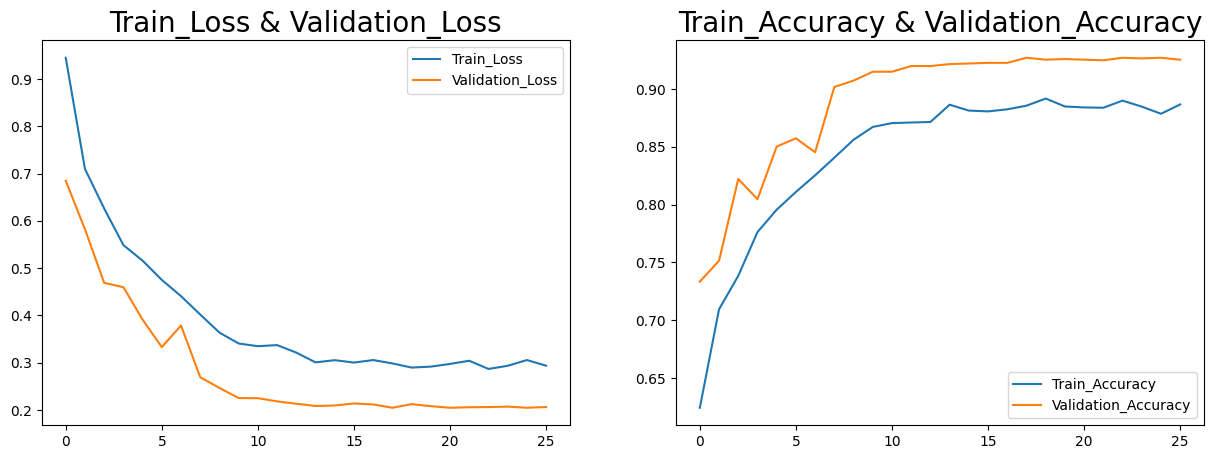

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_acc'],label='Train_Accuracy')
plt.plot(logs['val_acc'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()